# Get full network with all nodes

In [1]:
from simulator import Simulator
from network import Network

from network import servers_csv_to_dict, pings_csv_to_dict

network = Network.from_dicts(pings_csv_to_dict("./../pings.csv"), servers_csv_to_dict("./../servers.csv"), fraction = 1)

## GossipSub

In [15]:
# Declare a data structure to store the results (stretch and anonymity)
# Define the hyper parameters
# Run the simulation

from dataclasses import dataclass
from gossip_algorithm import GossipSub
from attacker import create_random_attackers, UniformEstimator, LowestTimeEstimator
import numpy as np

sample_size = 100

fanout = int

@dataclass
class Result:
    Stretch: float
    StretchStdDev: float
    Accuracy: float
    AccuracyStdDev: float

data: dict[fanout, Result] = {}

fanouts = list(range(5, 10 + 1))

for f_o in fanouts:

    print(f"Running simulation for fanout {f_o}")

    simulator = Simulator(network=network, gossip_algorithm=GossipSub(network, fanout = f_o))
    all_nodes = [node.node_id for node in simulator.network.nodes]

    stretches_gs = []
    stretches_gs_stddev = []
    attacks_gs = []
    attacks_gs_stddev = []

    total_stretch_samples = 0
    total_attack_samples = 0

    for i in range(sample_size):
        simulator.setup()
        lst_attackers = create_random_attackers(UniformEstimator, all_nodes, simulator.first_source.node_id, 0.1, num_attackers = 100)
        lst_attackers += create_random_attackers(LowestTimeEstimator, all_nodes, simulator.first_source.node_id, 0.1, num_attackers = 100)
        stretch, attack  = simulator.run(attackers = lst_attackers, msg_receival_limit = 1)
        stretches_gs += stretch.values
        attacks_gs += attack.values
        stretches_gs_stddev += [np.std(stretch.values)]
        attacks_gs_stddev += [np.std(attack.values)]

        total_stretch_samples += len(stretch.values)
        total_attack_samples += len(attack.values)

    stretch_avg = sum(stretches_gs) / total_stretch_samples
    stretch_std_dev = sum(stretches_gs_stddev) / sample_size
    attack_avg = sum(attacks_gs) / total_attack_samples
    attack_std_dev = sum(attacks_gs_stddev) / sample_size

    data[f_o] = Result(stretch_avg, stretch_std_dev, attack_avg, attack_std_dev)



Running simulation for fanout 5
- Stretch samples: 24500
- Attack samples: 20000
Running simulation for fanout 6
- Stretch samples: 24500
- Attack samples: 20000
Running simulation for fanout 7
- Stretch samples: 24500
- Attack samples: 20000
Running simulation for fanout 8
- Stretch samples: 24500
- Attack samples: 20000
Running simulation for fanout 9
- Stretch samples: 24500
- Attack samples: 20000
Running simulation for fanout 10
- Stretch samples: 24500
- Attack samples: 20000


In [16]:
data

{5: Result(Stretch=3.613521777169658, StretchStdDev=5.188717163800919, Accuracy=0.2297, AccuracyStdDev=0.41325190106717885),
 6: Result(Stretch=2.935627649969933, StretchStdDev=3.8716902926189563, Accuracy=0.2287, AccuracyStdDev=0.4130642215344964),
 7: Result(Stretch=2.7251759039602477, StretchStdDev=3.370941643786403, Accuracy=0.2485, AccuracyStdDev=0.42441360771201625),
 8: Result(Stretch=2.4787294820968615, StretchStdDev=2.8862034054706864, Accuracy=0.25665, AccuracyStdDev=0.42823817481455445),
 9: Result(Stretch=2.2966220827678163, StretchStdDev=3.0899301600451254, Accuracy=0.2682, AccuracyStdDev=0.4338351050763924),
 10: Result(Stretch=2.108170872417462, StretchStdDev=3.2034050805650445, Accuracy=0.2584, AccuracyStdDev=0.4278604571627749)}

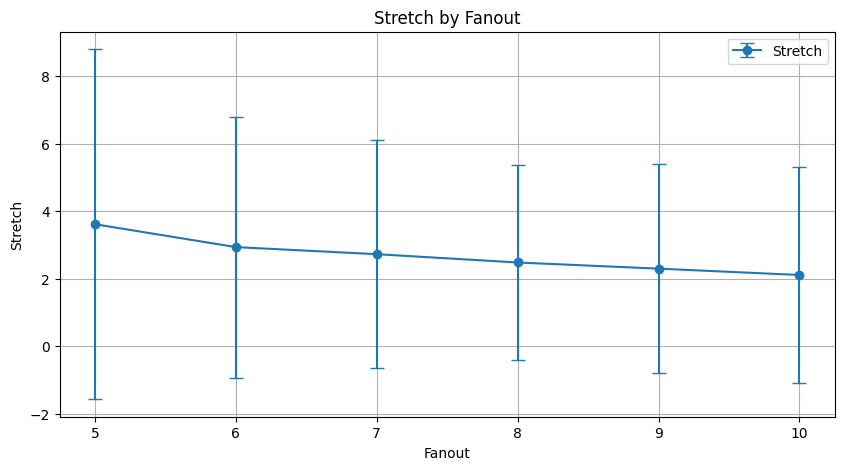

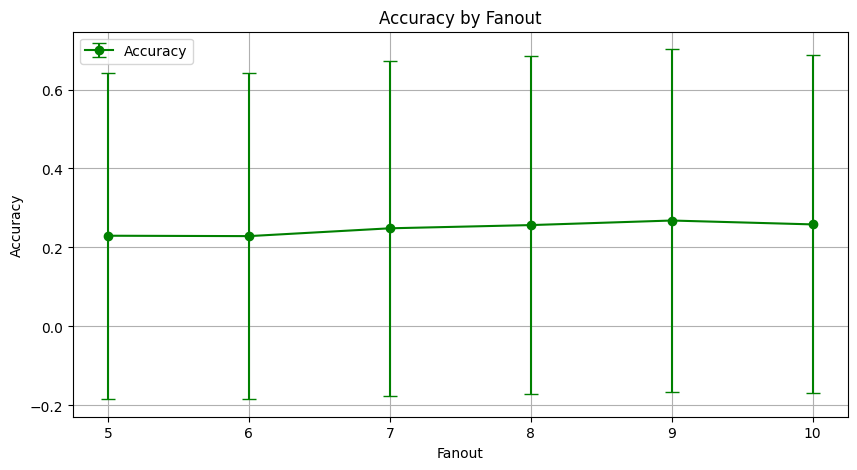

In [17]:
import matplotlib.pyplot as plt

# Extract data for plotting
fanouts = list(data.keys())
stretches = [data[f].Stretch for f in fanouts]
stretch_std_devs = [data[f].StretchStdDev for f in fanouts]
accuracies = [data[f].Accuracy for f in fanouts]
accuracy_std_devs = [data[f].AccuracyStdDev for f in fanouts]

# Plot Stretch by fanout
plt.figure(figsize=(10, 5))
plt.errorbar(fanouts, stretches, yerr=stretch_std_devs, fmt='-o', capsize=5, label='Stretch')
plt.xlabel('Fanout')
plt.ylabel('Stretch')
plt.title('Stretch by Fanout')
plt.grid(True)
plt.legend()
plt.show()

# Plot Accuracy by fanout
plt.figure(figsize=(10, 5))
plt.errorbar(fanouts, accuracies, yerr=accuracy_std_devs, fmt='-o', capsize=5, label='Accuracy', color='green')
plt.xlabel('Fanout')
plt.ylabel('Accuracy')
plt.title('Accuracy by Fanout')
plt.grid(True)
plt.legend()
plt.show()

## Hierarchical

In [19]:
# Declare a data structure to store the results (stretch and anonymity)
# Define the hyper parameters
# Run the simulation

sample_size = 100

Rho = float
BernoulliP = float

data: dict[BernoulliP, dict[Rho, Result]] = {}

from gossip_algorithm import HierarchicalIntraCobraWalkInterBernoulliWithVoronoi
from attacker import create_random_attackers, UniformEstimator, LowestTimeEstimator

# bernoulli_ps = [0.1, 0.3, 0.5, 0.7, 0.9]
# rhos = [0.1, 0.3, 0.5, 0.7, 0.9]

bernoulli_ps = [0.1, 0.5]
rhos = [0.5, 0.8]

for b_p in bernoulli_ps:

    print(f"Running simulation for BernoulliP {b_p}")

    data[b_p] = {}

    for rho in rhos:

        print(f"- Running simulation for Rho {rho}")

        simulator = Simulator(network=network, gossip_algorithm=HierarchicalIntraCobraWalkInterBernoulliWithVoronoi(network,
                                                                                                                    inter_cluster_probability = b_p,
                                                                                                                    intra_cobra_walk_rho = rho, fanout_inter = 3, num_clusters = 8))
        all_nodes = [node.node_id for node in simulator.network.nodes]

        stretches_h = []
        stretches_stddev = []
        attacks_h = []
        attacks_stddev = []
    
        total_stretch_samples = 0
        total_attack_samples = 0

        for i in range(sample_size):
            simulator.setup()
            lst_attackers = create_random_attackers(UniformEstimator, all_nodes, simulator.first_source.node_id, 0.1, num_attackers = 10)
            lst_attackers += create_random_attackers(UniformEstimator, all_nodes, simulator.first_source.node_id, 0.1, num_attackers = 10)
            stretch, attack  = simulator.run(attackers = lst_attackers, msg_receival_limit = 60)
            stretches_h += stretch.values
            attacks_h += attack.values
            stretches_stddev.append(np.std(stretch.values))
            attacks_stddev.append(np.std(attack.values))

            total_stretch_samples += len(stretch.values)
            total_attack_samples += len(attack.values)

        stretch_avg = sum(stretches_h) / total_stretch_samples
        stretch_std_dev = sum(stretches_stddev) / sample_size
        attack_avg = sum(attacks_h) / total_attack_samples
        attack_std_dev = sum(attacks_stddev) / sample_size

        data[b_p][rho] = Result(stretch_avg, stretch_std_dev, attack_avg, attack_std_dev)


Running simulation for BernoulliP 0.1
- Running simulation for Rho 0.5


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


- Running simulation for Rho 0.8


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Running simulation for BernoulliP 0.5
- Running simulation for Rho 0.5


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


- Running simulation for Rho 0.8


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [20]:
data

{0.1: {0.5: Result(Stretch=5.752327150453653, StretchStdDev=5.505998520314997, Accuracy=0.089, AccuracyStdDev=0.21422336756310797),
  0.8: Result(Stretch=4.243448194220713, StretchStdDev=3.765412374501726, Accuracy=0.0975, AccuracyStdDev=0.23476755094004612)},
 0.5: {0.5: Result(Stretch=nan, StretchStdDev=nan, Accuracy=0.0885, AccuracyStdDev=0.20977186955994032),
  0.8: Result(Stretch=nan, StretchStdDev=nan, Accuracy=0.064, AccuracyStdDev=0.1628982410442856)}}

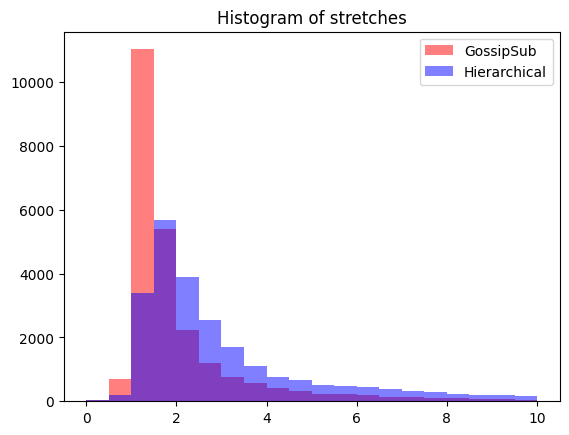

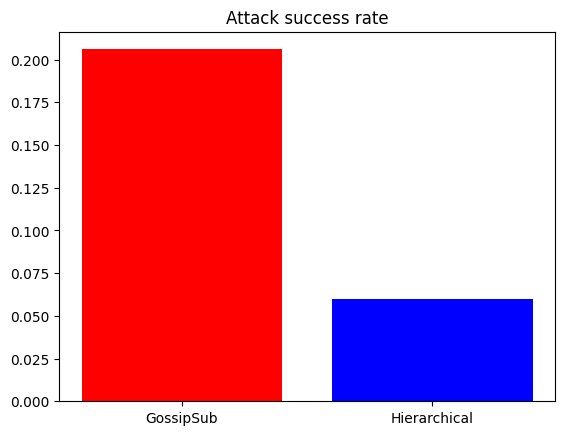

In [4]:
# Histograms
import matplotlib.pyplot as plt
import numpy as np

all_stretches_gs = [stretch.values for stretch in stretches_gs]
all_stretches_gs = [item for sublist in all_stretches_gs for item in sublist]
all_stretches_h = [stretch.values for stretch in stretches_h]
all_stretches_h = [item for sublist in all_stretches_h for item in sublist]
all_attacks_gs = [attack.values for attack in attacks_gs]
all_attacks_gs = [item for sublist in all_attacks_gs for item in sublist]
all_attacks_h = [attack.values for attack in attacks_h]
all_attacks_h = [item for sublist in all_attacks_h for item in sublist]

plt.hist(all_stretches_gs, bins = 20, range = (0, 10), color = 'r', alpha = 0.5, label = "GossipSub")
plt.hist(all_stretches_h, bins = 20, range = (0, 10), color = 'b', alpha = 0.5, label = "Hierarchical")
plt.legend(loc='upper right')
plt.title("Histogram of stretches")
plt.show()

# attack success rate
success_rate_gs = np.mean(all_attacks_gs)
success_rate_h = np.mean(all_attacks_h)
plt.bar(["GossipSub", "Hierarchical"], [success_rate_gs, success_rate_h], color = ['r', 'b'])
plt.title("Attack success rate")
plt.show()

